# Progetto di Classificazione di Forme Geometriche da Sequenze di Punti

## Obiettivo del progetto

Lo scopo di questo progetto è sviluppare un sistema automatico in grado di riconoscere forme geometriche semplici - ellissi, rettangoli, segmenti e coppie di segmenti che si incrociano in modo ortogonale, a croce - a partire da sequenze di punti che ne rappresentano il contorno.

## Dataset
Il dataset viene calcolato in modo sintetico per mezzo della funzione _genera_campioni_, che determina una sequenza di punti per ogni forma, aggiungendo un eventuale rumore gaussiano.
Si consideri inizialmente un dataset composto da **4000 forme** (1000 per tipo) ognuna descritta da 100 punti, ordinati secondo l'ordine di generazione dell'algoritmo utilizzato, con associato il relativo target, sotto forma di un intero tra 0 e 3, associato a una label per la forma dalla lista labels. 


200 valori rappresenta un campione etichettato costituito da una sequenza di numeri in vergola mobile $x_1\ y_1\ x_2\ y_2\ \ldots x_{100}\ y_{100}$ che rappresentano le $200$ coordinate dei $100$  punti che descrivono il perimetro della forma, seguita da una etichetta testuale (ellisse, rettangolo, segmento, croce) che indica la forma rappresentata.

## Compiti dello studente

Lo studente dovrà progettare un **classificatore automatico** in grado di riconoscere correttamente la forma rappresentata da ciascuna sequenza. Il progetto richiede di affrontare i seguenti step:

### 1. Rappresentazione e feature engineering
Definire una rappresentazione vettoriale delle forme implementando la funzione _ottieni_features_. Nel codice, viene fornita una implementazione di tale funzione corrispondente ad una banale rappresentazione in cui l'insieme di punti $(x_1,y_1), \ldots, (x_n, y_n)$ è rappresentato da un vettore $x_1,y_1, \ldots,x_n, y_n$. Si valuti l'utilizzo di rappresetazioni diverse sia utilizzando metodi algoritmici (feature selection, feature extraction) che definendo nuove features (es. distanza dal centroide, perimetro e distanza tra punti estremi, etc.).

Ciascun campione, forma, sarà descritta dalle seguenti feature:

- **Vettore dei punti**
- **Distanza dal centroide** (Da definire) 
    $$  
        \text{centroide}_x = \frac{1}{N} \sum_{i=1}^{N} x_i, \quad
        \text{centroide}_y = \frac{1}{N} \sum_{i=1}^{N} y_i
    $$
- **Perimetro**
- **Deviazione std x e y** -> **rapporto tra le due** (da definire)
- **Distanza tra punti estremi** (da definire)
- **Distanza massima tra punti** 
    $$
        \max_{i,j}\{\sqrt((x_i - x_j)^2 + (y_i - y_j)^2)\}
    $$
- **Area convessa** (da definire)
- **Area**

### 2. Costruzione e valutazione di classificatori

- Utilizzare le caratteristiche estratte per addestrare e confrontare un insieme di classificatori, valutando anche il valore ottimo (o sufficientemente buono) di iperparametri definiti per il classificatore considerato (model selection), utilizzano un validation set o la cross-validation
- Valutare le prestazioni dei vari modelli su un test set anch'esso sintetico, derivato dal dataset calcolato mediante splitting o anche prodotto utilizzando il medesimo algoritmo.
- Esaminare e confrontare le prestazioni ottenute sul training e sul test set e controllare l'eventaule overfitting

### 3. Test di robustezza
Analizzare l'effetto sulle prestazioni ottenute dai vari modelli, e su quelle del miglior classificatore di
- Quantità di forme disponibili come esempio
- Numero di punti che descrivono la singola forma
- Quantità di rumore gaussiano
Analizzare inoltre la differenza di prestazioni al variare del dataset considerato, prodotto comunque secondo il medesimo algoritmo.

### 4. Classificazione binaria
Considerare il problema di classificazione binaria derivato considerando la classe delle forme con area nulla (segmento, croce) vs. la classe di quelle ad area positiva (ellisse, rettangolo), unendo quindi da un lato le classi 0 e 1 e dall'altro le classi 2,3. Analizzare le prestazioni ottenute sul problema secondo le indicazioni precedenti.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import csv

def to_stringa(punti, forma):
    return ";".join(f"{x:.3f}:{y:.3f}" for x, y in punti)+','+forma

def print_forma(n, X, y, labels):
    for x_i, y_i in zip(X[:n], y[:n]):
        print(to_stringa(x_i, labels[y_i]))
        
def plot_forma(n, X, y, labels):
    """
    Visualizza le prime n forme di X con le etichette y utilizzando matplotlib.
    Ogni forma è rappresentata unendo i suoi punti, colorata in base alla sua etichetta.

    Args:
        n (int): numero di forme da visualizzare
        X (list of np.ndarray): lista di array (uno per forma) di shape (n_punti, 2)
        y (np.ndarray): array di interi con le etichette corrispondenti alle forme
        labels (list of str): nomi delle etichette per le forme
    """
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm

    colori = cm.get_cmap('tab10', len(labels))  # Mappa colori diversa per ogni etichetta
    plt.figure(figsize=(8, 8))

    for i in range(n):
        punti = X[i]
        etichetta = y[i]
        nome = labels[etichetta]
        colore = colori(etichetta)

        # Collega i punti con una linea per visualizzare la forma
        plt.plot(punti[:, 0], punti[:, 1], label=nome if i == 0 else "", color=colore)
        # (opzionale: mostra anche i punti singoli)
        # plt.scatter(punti[:, 0], punti[:, 1], color=colore, s=10)

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Visualizzazione Forme Geometriche')
    plt.grid(True)
    plt.axis('equal')  # Mantiene le proporzioni corrette tra X e Y
    plt.show()


def genera_segmento(x0, y0, theta, l, n_punti=50, rumore_std = 0.01):
    """
    Genera un segmento rettilineo con n_punti, tra due estremi calcolati a partire da un punto centrale (x0, y0),
    una lunghezza totale l e un angolo theta rispetto all'asse x. I punti sono distribuiti uniformemente lungo il segmento,
    con l'aggiunta opzionale di rumore gaussiano.

    Args:odel selection), utilizzano un validation set o la cross-validation
- Valutare le prestazioni dei vari modelli su un test set anch'esso sintetico, 
        x0 (float): coordinata x del punto centrale del segmento
        y0 (float): coordinata y del punto centrale del segmento
        theta (float): angolo del segmento rispetto all'asse x (in radianti)
        l (float): metà lunghezza del segmento (il segmento totale sarà lungo 2*l)
        n_punti (int): numero di punti da generare lungo il segmento
        rumore_std (float): deviazione standard del rumore gaussiano da aggiungere ai punti

    Returns:
        np.ndarray: array di shape (n_punti, 2) contenente le coordinate dei punti generati
    """
    # Calcola le coordinate dei due estremi del segmento
    x1 = x0 + l * np.cos(theta)
    y1 = y0 + l * np.sin(theta)
    x2 = x0 - l * np.cos(theta)
    y2 = y0 - l * np.sin(theta)
    # Interpolazione lineare tra i due estremi per ottenere i punti
    t = np.linspace(0, 1, n_punti) # n valori tra 0 - 1
    x = x1 + t * (x2 - x1)
    y = y1 + t * (y2 - y1)
    # Aggiunta di rumore gaussiano alle coordinate
    x += np.random.normal(0, rumore_std, size=n_punti)
    y += np.random.normal(0, rumore_std, size=n_punti)
    # Restituisce un array Nx2 con i punti generati
    return np.stack([x, y], axis=1)  # shape: (n_punti, 2)

def genera_croce(x0, y0, theta, l, n_punti=50, rumore_std = 0.01):
    """
    Genera una croce composta da due segmenti ortogonali che si intersecano nel punto (x0, y0).
    Ogni segmento è centrato in (x0, y0), ha lunghezza totale 2*l e angolo theta (il secondo segmento è ruotato di 90° rispetto al primo).
    I punti sono distribuiti uniformemente lungo i segmenti, con aggiunta opzionale di rumore gaussiano.

    Args:
        x0 (float): coordinata x del centro della croce
        y0 (float): coordinata y del centro della croce
        theta (float): angolo del primo segmento rispetto all'asse x (in radianti)
        l (float): metà lunghezza di ciascun segmento (ogni segmento è lungo 2*l)
        n_punti (int): numero totale di punti da generare (divisi equamente tra i due segmenti)
        rumore_std (float): deviazione standard del rumore gaussiano da aggiungere ai punti

    Returns:
        np.ndarray: array di shape (n_punti, 2) contenente le coordinate dei punti generati
    """
    # Primo segmento (angolo theta)
    x1 = x0 + l * np.cos(theta)
    y1 = y0 + l * np.sin(theta)
    x2 = x0 - l * np.cos(theta)
    y2 = y0 - l * np.sin(theta)
    t = np.linspace(0, 1, n_punti//2)
    x = x1 + t * (x2 - x1)
    y = y1 + t * (y2 - y1)
    x += np.random.normal(0, rumore_std, size=n_punti//2)
    y += np.random.normal(0, rumore_std, size=n_punti//2)

    # Secondo segmento (angolo theta + 90°)
    x1 = x0 - l * np.sin(theta)
    y1 = y0 + l * np.cos(theta)
    x2 = x0 + l * np.sin(theta)
    y2 = y0 - l * np.cos(theta)
    t = np.linspace(0, 1, n_punti//2)
    xx = x1 + t * (x2 - x1)
    yy = y1 + t * (y2 - y1)
    xx += np.random.normal(0, rumore_std, size=n_punti//2)
    yy += np.random.normal(0, rumore_std, size=n_punti//2)

    # Unisce i punti dei due segmenti
    x = np.concatenate([x, xx])
    y = np.concatenate([y, yy])

    return np.stack([x, y], axis=1)  # shape: (n_punti, 2)



def genera_ellisse(a=1.0, b=0.5, centro=(0, 0), angolo=0.0, n_punti=100, rumore_std=0.0):
    """
    Genera punti su un'ellisse centrata in `centro`, con semiassi `a` e `b`,
    ruotata di `angolo` radianti, e opzionalmente con rumore gaussiano.

    Parametri:
    - a (float): semiasse maggiore
    - b (float): semiasse minore
    - centro (tuple): coordinate del centro (x0, y0)
    - angolo (float): rotazione in radianti (es. np.pi/4 per 45°)
    - n_punti (int): numero di punti da generare
    - rumore_std (float): deviazione standard del rumore gaussiano da aggiungere

    Ritorna:
    - array Nx2 con i punti [x, y]
    """
    
    t = np.linspace(0, 2 * np.pi, n_punti)
    x = a * np.cos(t)
    y = b * np.sin(t)

    # Rotazione
    x_rot = x * np.cos(angolo) - y * np.sin(angolo)
    y_rot = x * np.sin(angolo) + y * np.cos(angolo)

    # Traslazione
    x_finale = x_rot + centro[0]
    y_finale = y_rot + centro[1]

    # Rumore
    x_finale += np.random.normal(0, rumore_std, size=n_punti)
    y_finale += np.random.normal(0, rumore_std, size=n_punti)

    return np.stack([x_finale, y_finale], axis=1)


def genera_rettangolo(larghezza=1.0, altezza=0.5, centro=(0, 0), angolo=0.0,
            rumore_std=0.0, n_punti=100):
    """
    Genera punti distribuiti lungo i 4 lati di un rettangolo ruotato e centrato,
    in modo proporzionale alla lunghezza dei lati.

    Args:
        larghezza (float): larghezza del rettangolo
        altezza (float): altezza del rettangolo
        centro (tuple): centro (x, y)
        angolo (float): rotazione in radianti
        rumore_std (float): rumore gaussiano (std dev)
        n_punti (int): numero totale di punti da generare

    Returns:
        np.ndarray: array (n_punti, 2) con i punti lungo i lati
    """
    if n_punti < 4:
        raise ValueError("n_punti deve essere almeno 4")

    # Vertici base
    w, h = larghezza / 2, altezza / 2
    vertici = np.array([
        [-w, -h],
        [ w, -h],
        [ w,  h],
        [-w,  h]
    ])

    # Lati e lunghezze
    lati = [(vertici[(i+1) % 4] - vertici[i]) for i in range(4)]
    lunghezze = np.array([np.linalg.norm(l) for l in lati])
    proporzioni = lunghezze / lunghezze.sum()

    # Distribuzione dei punti
    n_per_lato = np.floor(proporzioni * n_punti).astype(int)
    restante = n_punti - n_per_lato.sum()
    for i in range(restante):
        n_per_lato[i % 4] += 1

    # Generazione dei punti
    punti = []
    for i, n in enumerate(n_per_lato):
        start = vertici[i]
        end = vertici[(i + 1) % 4]
        t_values = np.linspace(0, 1, n, endpoint=False)
        lato = np.outer(1 - t_values, start) + np.outer(t_values, end)
        punti.append(lato)
    punti = np.vstack(punti)

    # Rotazione, traslazione e rumore
    R = np.array([
        [np.cos(angolo), -np.sin(angolo)],
        [np.sin(angolo),  np.cos(angolo)]
    ])
    punti = punti @ R.T
    punti += np.array(centro)
    punti += np.random.normal(0, rumore_std, punti.shape)

    return punti

Genera istanze sintetiche

In [229]:
def genera_campioni(n_shapes = 100, n_punti = 50, rumore_std_bound=0):
    """
    Genera un dataset sintetico di forme geometriche (ellissi, rettangoli, segmenti e croci)
    rappresentate come sequenze di punti 2D, con etichette numeriche.

    Parametri:
        n_shapes (int): Numero di istanze da generare per ciascuna classe di forma.
        n_punti (int): Numero di punti che descrivono ciascuna forma.
        rumore_std_bound (float): Valore massimo della deviazione standard del rumore gaussiano
                                  aggiunto alle coordinate dei punti.

    Restituisce:
        X (np.ndarray): Array di shape (4*n_shapes, n_punti, 2) contenente i punti delle forme.
        y (np.ndarray): Array di shape (4*n_shapes,) contenente le etichette numeriche delle forme:
                        0=ellisse, 1=rettangolo, 2=segmento, 3=croce.

    Ogni forma viene generata con parametri casuali (dimensioni, posizione, rotazione, rumore).
    """

    X, y = [], []  # Liste per memorizzare i campioni e le etichette

    # Genera ellissi
    for _ in range(n_shapes):
        a = np.random.uniform(0.5, 3.0)                  # semiasse maggiore
        b = np.random.uniform(0.3, a)                    # semiasse minore
        centro = (np.random.uniform(-5, 5), np.random.uniform(-5, 5))  # centro casuale
        angolo = np.random.uniform(0, 2 * np.pi)         # rotazione casuale
        rumore = np.random.uniform(0.0, rumore_std_bound)  # rumore casuale
        punti = genera_ellisse(a, b, centro, angolo, n_punti=n_punti, rumore_std=rumore)  # genera punti
        X.append(punti)
        y.append(0)  # 0 = ellisse

    # Genera rettangoli
    for _ in range(n_shapes):
        punti = genera_rettangolo(
            larghezza=np.random.uniform(0.5, 3.0),       # larghezza casuale
            altezza=np.random.uniform(0.5, 2.0),         # altezza casuale
            centro=(np.random.uniform(-5, 5), np.random.uniform(-5, 5)),  # centro casuale
            angolo=np.random.uniform(0, 2*np.pi),        # rotazione casuale
            rumore_std = np.random.uniform(0.0, rumore_std_bound),        # rumore casuale
            n_punti = n_punti
        )
        X.append(punti)
        y.append(1) # 1 = rettangolo

    # Genera segmenti
    for _ in range(n_shapes):
        x0, y0 = np.random.uniform(-5, 5 ), np.random.uniform(-5, 5 )  # centro casuale
        l, theta = np.random.uniform(0, 10 ), np.random.uniform(0, np.pi )  # lunghezza e angolo casuali
        punti = genera_segmento(x0, y0, l, theta, n_punti=n_punti,
                                rumore_std = np.random.uniform(0.0, rumore_std_bound))  # genera punti
        X.append(punti)
        y.append(2)
        
    # Genera croci (due segmenti ortogonali)
    for _ in range(n_shapes):
        x0, y0 = np.random.uniform(-5, 5 ), np.random.uniform(-5, 5 )  # centro casuale
        l, theta = np.random.uniform(0, 10 ), np.random.uniform(0, np.pi )  # lunghezza e angolo casuali
        punti = genera_croce(x0, y0, l, theta, n_punti=n_punti,
                                rumore_std = np.random.uniform(0.0, rumore_std_bound))  # genera punti
        X.append(punti)
        y.append(3)  # 3 = croce
    return np.array(X), np.array(y)  # restituisce array di campioni e etichette

In [230]:
labels = ['ellisse', 'rettangolo', 'segmento', 'croce']

In [231]:
def esporta_dataset(filename, X, y):
    """
    Esporta un dataset di forme geometriche su file.

    Ogni riga del file conterrà le coordinate appiattite di una forma,
    separate da virgole, seguite dalla label testuale corrispondente.

    Args:
        filename (str): Nome del file di output.
        X (np.ndarray): Array di forme, ciascuna rappresentata da una sequenza di punti 2D.
        y (np.ndarray): Array di etichette numeriche delle forme.

    Returns:
        None
    """
    # Apre il file in modalità scrittura
    with open(filename, "w") as f:
        # Itera su ogni coppia di campione (x) e label (l)
        for x, l in zip(X, y):
            # Appiattisce l'array x, lo converte in stringa senza parentesi quadre,
            # aggiunge la label testuale corrispondente e va a capo
            f.write(np.array2string(x.flatten(), max_line_width=np.inf)[1:-1] + ',' + labels[l] + '\n')

In [232]:
def get_vector_representation(X):
    """
    Converte una sequenza di array di punti 2D (shape: N, n_punti, 2)
    in una rappresentazione vettoriale piatta (shape: N, n_punti*2).

    Ogni forma viene "appiattita" in un unico vettore concatenando tutte le coordinate x e y.

    Args:
        X (np.ndarray): array di forme, ciascuna rappresentata da una sequenza di punti 2D.

    Returns:
        np.ndarray: array 2D dove ogni riga è la rappresentazione vettoriale di una forma.
    """
    return np.array([list(x.flatten()) for x in X])

In [248]:
def ottieni_features(X):
    return get_vector_representation(X)

In [273]:
X, y = genera_campioni(n_shapes=1000, n_punti=100, rumore_std_bound=0)

In [235]:
y

array([0, 0, 0, ..., 3, 3, 3], shape=(4000,))

-4.151:-1.146;-4.166:-1.167;-4.178:-1.189;-4.189:-1.213;-4.197:-1.238;-4.202:-1.264;-4.206:-1.291;-4.207:-1.320;-4.206:-1.349;-4.202:-1.380;-4.196:-1.411;-4.188:-1.443;-4.178:-1.475;-4.165:-1.507;-4.150:-1.540;-4.134:-1.573;-4.115:-1.605;-4.094:-1.638;-4.071:-1.670;-4.047:-1.702;-4.021:-1.733;-3.993:-1.764;-3.964:-1.793;-3.934:-1.822;-3.902:-1.850;-3.869:-1.876;-3.836:-1.902;-3.801:-1.925;-3.766:-1.948;-3.730:-1.969;-3.694:-1.988;-3.657:-2.005;-3.621:-2.021;-3.584:-2.035;-3.548:-2.047;-3.512:-2.056;-3.477:-2.064;-3.442:-2.070;-3.408:-2.074;-3.375:-2.076;-3.342:-2.076;-3.311:-2.073;-3.282:-2.069;-3.253:-2.062;-3.227:-2.054;-3.201:-2.043;-3.178:-2.031;-3.156:-2.016;-3.137:-2.000;-3.119:-1.982;-3.103:-1.962;-3.090:-1.941;-3.079:-1.918;-3.069:-1.894;-3.063:-1.868;-3.058:-1.841;-3.056:-1.813;-3.056:-1.784;-3.058:-1.754;-3.063:-1.723;-3.070:-1.692;-3.079:-1.660;-3.091:-1.628;-3.104:-1.595;-3.120:-1.562;-3.138:-1.530;-3.158:-1.497;-3.179:-1.465;-3.203:-1.432;-3.228:-1.401;-3.255:-1.370;-3.283

/tmp/ipykernel_21613/3687843362.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colori = cm.get_cmap('tab10', len(labels))  # Mappa colori diversa per ogni etichetta


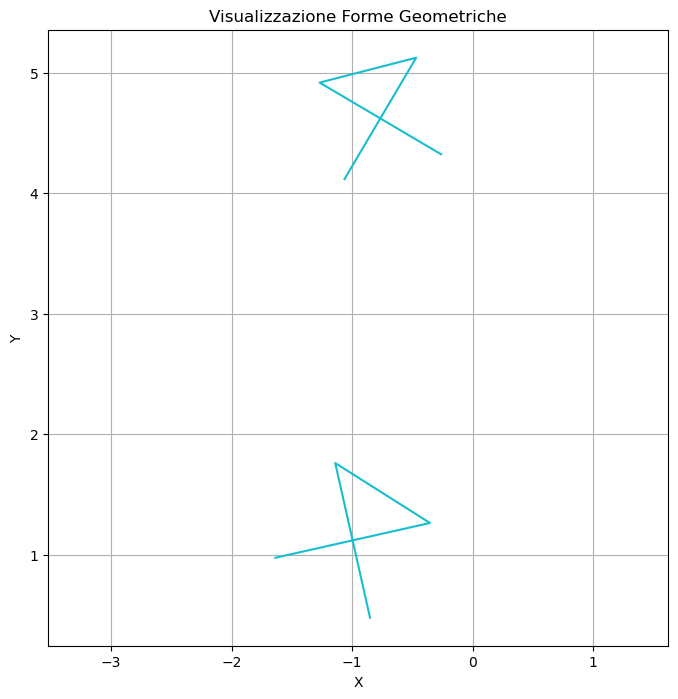

In [274]:
print_forma(2, X, y, labels)
plot_forma(2, X[3000:], y[3000:], labels)

In [237]:
print("Shape di X:", X.shape)
print("Shape di y:", y.shape)

Shape di X: (4000, 100, 2)
Shape di y: (4000,)


In [238]:
X_f = ottieni_features(X)

In [239]:
print("Shape di X_f:", X_f.shape)
print("Shape di y:", y.shape)

Shape di X_f: (4000, 200)
Shape di y: (4000,)


Esempio elementare di applicazione di un classificatore e di valutazione in termini di accuracy

In [240]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_f, y, test_size=0.3, random_state=42, stratify=y)
print("Shape X_train:", X_train.shape)
print("Shape X_test:", X_test.shape)
print("Shape y_train:", y_train.shape)
print("Shape y_test:", y_test.shape)

Shape X_train: (2800, 200)
Shape X_test: (1200, 200)
Shape y_train: (2800,)
Shape y_test: (1200,)


In [241]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)
acc = accuracy_score(y_train, y_pred)
print(f"Accuracy sul training set: {acc:.4f}")
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy sul test set: {acc:.4f}")

Accuracy sul training set: 1.0000
Accuracy sul test set: 0.7992
